# Assignment Feature engineering 2: dimensionality and PCA

Say, we want to understand the relationship between the expenditures of the governments and the students' overall success in the math and reading.

1. Create a new score variable from the weighted averages of all score variables in the datasets. **Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!**.
2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?
3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?
4. What is the correlation between the overall score variable and the 1st principal component? 
5. If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
from sqlalchemy import create_engine
import warnings

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
sns.set(style="dark")

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

US_EDU = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
US_EDU.describe(include='all')

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
count,1492,1492,1492.000000,1.229000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,...,1361.000000,1361.000000,1361.00000,1.361000e+03,1.361000e+03,1.319000e+03,536.000000,532.000000,533.000000,498.000000
unique,1487,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2008_VIRGINIA,DISTRICT_OF_COLUMBIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2004.433646,9.159308e+05,9.092082e+06,7.663723e+05,4.216553e+06,4.109157e+06,9.196681e+06,4.762966e+06,...,64538.927259,64271.057311,54268.92432,5.192140e+05,2.470714e+05,8.024415e+05,234.768293,278.414711,218.866154,263.661132
std,NaN,NaN,7.393983,1.065280e+06,1.174519e+07,1.145242e+06,5.543072e+06,5.482971e+06,1.197813e+07,6.293004e+06,...,80293.387625,78910.545776,67889.27623,6.436384e+05,3.077056e+05,9.707031e+05,10.221511,10.159722,7.769616,6.803725
min,NaN,NaN,1992.000000,4.386600e+04,4.656500e+05,3.102000e+04,0.000000e+00,2.209300e+04,4.816650e+05,2.655490e+05,...,633.000000,437.000000,311.00000,4.878000e+03,1.808000e+03,7.254000e+03,187.134670,232.831510,178.557612,236.379102
25%,NaN,NaN,1998.000000,2.583140e+05,2.186305e+06,1.893540e+05,1.153097e+06,7.158345e+05,2.165404e+06,1.168032e+06,...,13739.000000,13342.000000,10919.00000,1.106260e+05,5.147100e+04,1.810650e+05,229.694352,272.761598,214.663401,259.533171
50%,NaN,NaN,2004.000000,6.483130e+05,5.079546e+06,4.033765e+05,2.537074e+06,2.055780e+06,5.234506e+06,2.657452e+06,...,43272.000000,43339.000000,36735.00000,3.457750e+05,1.642600e+05,5.503420e+05,237.238552,280.618803,220.416034,265.010912
75%,NaN,NaN,2011.000000,1.014528e+06,1.085985e+07,8.289660e+05,5.080939e+06,4.768680e+06,1.074519e+07,5.568028e+06,...,75481.000000,76566.000000,67460.00000,6.119050e+05,2.905020e+05,9.282755e+05,241.995486,285.347428,223.999337,268.190121


In [4]:
fill_list = ["ENROLL", "TOTAL_REVENUE", "FEDERAL_REVENUE",
             "STATE_REVENUE", "LOCAL_REVENUE", "TOTAL_EXPENDITURE",
             "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
             "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", "GRADES_PK_G",
             "GRADES_KG_G", "GRADES_4_G", "GRADES_8_G", "GRADES_12_G", "GRADES_1_8_G",
             "GRADES_9_12_G", "GRADES_ALL_G"]

STATES = US_EDU["STATE"].unique()

# were using interpolation because the data is time related
for state in STATES:
    US_EDU.loc[US_EDU["STATE"] == state, fill_list] = US_EDU.loc[US_EDU["STATE"] == state, fill_list].interpolate()

# we drop the null values after interpolation
US_EDU.dropna(inplace=True)

In [5]:
US_EDU.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
209,1996_ALABAMA,ALABAMA,1996,735912.0,3365113.0,334858.0,2138717.0,891538.0,3572283.0,1987018.0,...,57098.0,58305.0,42510.0,469370.0,207980.0,686983.0,211.646974,256.594863,210.920767,260.276441
211,1996_ARIZONA,ARIZONA,1996,764681.0,4143304.0,378917.0,1798363.0,1966024.0,4391555.0,1860007.0,...,62793.0,60514.0,42041.0,511925.0,210289.0,726709.0,217.575940,267.874834,206.529788,263.283638
212,1996_ARKANSAS,ARKANSAS,1996,452907.0,2183384.0,192152.0,1296247.0,694985.0,2297381.0,1264275.0,...,33855.0,37064.0,27613.0,283883.0,131997.0,417860.0,215.846436,261.652745,208.837716,271.834590
213,1996_CALIFORNIA,CALIFORNIA,1996,5460484.0,31282981.0,2603882.0,17061474.0,11617625.0,31561692.0,16880730.0,...,435217.0,406456.0,298669.0,3516572.0,1525618.0,5115423.0,209.129083,262.772478,201.912591,269.197451
214,1996_COLORADO,COLORADO,1996,655679.0,3891203.0,194998.0,1664676.0,2031529.0,4075165.0,2052264.0,...,52524.0,52269.0,37179.0,423510.0,185700.0,621730.0,225.805858,275.608214,221.653243,268.168154


In [6]:
US_EDU.describe(include='all')

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
count,466,466,466.000000,4.660000e+02,4.660000e+02,4.660000e+02,4.660000e+02,4.660000e+02,4.660000e+02,4.660000e+02,...,466.00000,466.00000,466.000000,4.660000e+02,4.660000e+02,4.660000e+02,466.000000,466.000000,466.000000,466.000000
unique,465,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2009_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2008.577253,9.442125e+05,1.078853e+07,9.568659e+05,4.999548e+06,4.832112e+06,1.086947e+07,5.638251e+06,...,72515.82618,72917.07618,64773.880901,5.836186e+05,2.867026e+05,8.933042e+05,236.909728,279.802668,219.508638,263.789943
std,NaN,NaN,5.779779,1.122051e+06,1.356335e+07,1.330702e+06,6.405481e+06,6.325995e+06,1.373667e+07,7.255903e+06,...,86463.95300,85835.16237,77557.604833,6.925615e+05,3.408161e+05,1.060080e+06,8.695903,9.381511,7.426546,6.875627
min,NaN,NaN,1996.000000,4.417900e+04,6.788740e+05,5.787000e+04,0.000000e+00,2.853100e+04,7.032450e+05,3.182600e+05,...,3423.00000,2860.00000,2188.000000,2.676200e+04,9.970000e+03,3.682300e+04,187.134670,232.831510,181.626990,236.379102
25%,NaN,NaN,2005.000000,2.794832e+05,2.712660e+06,2.614470e+05,1.491747e+06,9.513430e+05,2.670300e+06,1.416288e+06,...,20489.75000,20880.25000,18527.750000,1.666395e+05,8.194400e+04,2.596278e+05,232.760641,274.707118,215.338956,259.661771
50%,NaN,NaN,2009.000000,6.639415e+05,6.106834e+06,5.544340e+05,3.021544e+06,2.442983e+06,6.249671e+06,3.186679e+06,...,50918.00000,50114.50000,41543.000000,4.067475e+05,1.868900e+05,6.264775e+05,238.394124,281.531587,221.130461,265.217081
75%,NaN,NaN,2013.000000,1.018588e+06,1.222407e+07,1.033414e+06,6.240349e+06,5.488079e+06,1.195951e+07,6.154768e+06,...,79929.50000,80949.75000,75641.250000,6.424952e+05,3.234915e+05,9.758625e+05,242.602566,286.197041,224.531280,268.307884


# Assignment 2.1: dimensionality and PCA


Create a new score variable from the weighted averages of all score variables in the datasets. **Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!**.

In [7]:
US_EDU["overall_score"] = (US_EDU["GRADES_4_G"]*((US_EDU["AVG_MATH_4_SCORE"] + US_EDU["AVG_READING_4_SCORE"])*0.5) + US_EDU["GRADES_8_G"]
                                 * ((US_EDU["AVG_MATH_8_SCORE"] + US_EDU["AVG_READING_8_SCORE"])*0.5))/(US_EDU["GRADES_4_G"] + US_EDU["GRADES_8_G"])

# Assignment 2.2: dimensionality and PCA

What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

In [8]:
CORR_US_EDU = US_EDU[["overall_score", 
                      "INSTRUCTION_EXPENDITURE",
                      "SUPPORT_SERVICES_EXPENDITURE",
                      "OTHER_EXPENDITURE",
                      "CAPITAL_OUTLAY_EXPENDITURE"]].corr()

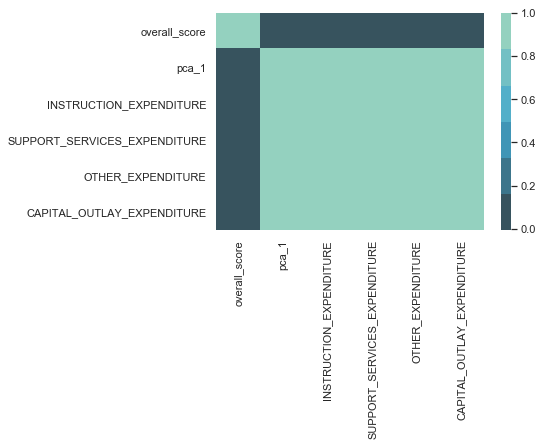

In [25]:
sns.heatmap(CORR_US_EDU, cmap=sns.color_palette("GnBu_d"))

In [10]:
CORR_US_EDU

,overall_score,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
overall_score,1.000000,0.087386,0.079002,0.010959,-0.005389
INSTRUCTION_EXPENDITURE,0.087386,1.000000,0.974399,0.902173,0.884798
SUPPORT_SERVICES_EXPENDITURE,0.079002,0.974399,1.000000,0.952282,0.911245
OTHER_EXPENDITURE,0.010959,0.902173,0.952282,1.000000,0.918188
CAPITAL_OUTLAY_EXPENDITURE,-0.005389,0.884798,0.911245,0.918188,1.000000


The vector most correlated with overall score is 'INSTRUCTION_EXPENDITURE.' Note weak correlations start at around .2 or .3 to .5 or .6. 

# Assignment 2.3: dimensionality and PCA

Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?

In [11]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(US_EDU[["INSTRUCTION_EXPENDITURE",
                                           "SUPPORT_SERVICES_EXPENDITURE",
                                           "OTHER_EXPENDITURE",
                                           "CAPITAL_OUTLAY_EXPENDITURE"]])
sklearn_pca = PCA(n_components=1)
US_EDU["pca_1"] = sklearn_pca.fit_transform(X)

print('The percentage of total variance in the dataset explained by each',
      'component from Sklearn PCA.\n',
      sklearn_pca.explained_variance_ratio_)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.9430175]


More than 94% of the total variance is explained by the first principal component.

In [12]:
# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
def Eigen_maker(X):
    Xt = X.transpose()
    Cx = np.cov(Xt)
    eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
#     # Inspecting the eigenvalues and eigenvectors.
#     for i in range(len(eig_val_cov)):
#         eigvec_cov = eig_vec_cov[:, i].T
    plt.plot(eig_val_cov)
    return 

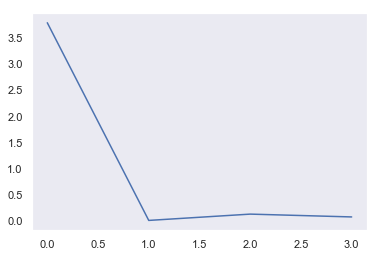

In [13]:
Eigen_maker(X)

## Assignment 2.4: dimensionality and PCA

What is the correlation between the overall score variable and the 1st principal component? 

In [14]:
CORR_US_EDU = US_EDU[["overall_score",
                      "pca_1",
                      "INSTRUCTION_EXPENDITURE",
                      "SUPPORT_SERVICES_EXPENDITURE",
                      "OTHER_EXPENDITURE",
                      "CAPITAL_OUTLAY_EXPENDITURE"]].corr()
CORR_US_EDU

,overall_score,pca_1,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
overall_score,1.000000,0.044596,0.087386,0.079002,0.010959,-0.005389
pca_1,0.044596,1.000000,0.968606,0.988345,0.971343,0.955792
INSTRUCTION_EXPENDITURE,0.087386,0.968606,1.000000,0.974399,0.902173,0.884798
SUPPORT_SERVICES_EXPENDITURE,0.079002,0.988345,0.974399,1.000000,0.952282,0.911245
OTHER_EXPENDITURE,0.010959,0.971343,0.902173,0.952282,1.000000,0.918188
CAPITAL_OUTLAY_EXPENDITURE,-0.005389,0.955792,0.884798,0.911245,0.918188,1.000000


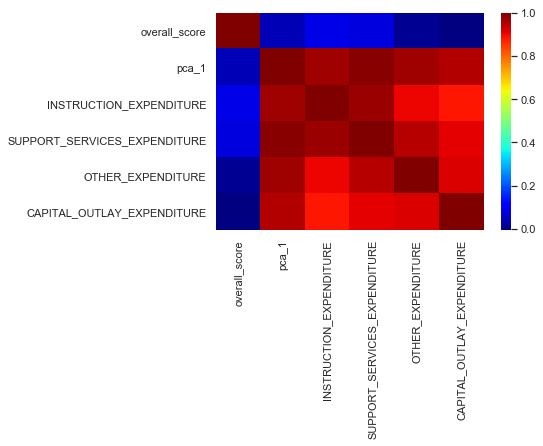

In [22]:
sns.heatmap(CORR_US_EDU, cmap='jet')

The overage score and first principle component are weakly correlated.

## Assignment 2.5: dimensionality and PCA

If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

I would chose the expenditure variables directly. The overall score is weakly corelated with all of these items, but the 1st principle conponent is less correlated with the overall score than the expenditure variables.

### Additional notes regarding Feature Selection Methods 

### Principal Components Analysis (PCA)

##### There are plenty of other methods to reduce dementionality

PCA is a complexity-reduction technique that tries to reduce a set of variables down to a smaller set of components that represent most of the information in the variables.  At a conceptual level, PCA works by identifying sets of variables that share variance and then creating a component to represent that variance. Some information is lost in this process. 

Losing variance in exchange for a smaller set of features can be worthwhile. Some model types (such as regression) assume that features will be uncorrelated with each other, and high levels of interfeature correlation create unstable solutions. Solutions with fewer features are easier to understand and are more computationally efficient. Solutions with fewer features are also less vulnerable to overfitting.

###### Things Get Messy
PCA works best for normally distributed data and assumes the relationships among variables are linear. PCA also works best when the variables involved range from weak to moderately strong correlations. Correlations of 0, or correlations greater than .7 or .8, create problems. Correlations near 0 mean there is no shared information. Correlations that are too high can result in components that are unstable and, therefore, change a lot in response to very small changes in the data or components made up of variance from only 1 or 2 variables. A few very high or very low correlations are fine. It is when we have a variable with mostly very high or very low correlations with other variables that problems can occur.
